### Import all the required libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import html5lib
import lxml
import requests
import keras
from bs4 import BeautifulSoup
import ast
from pandas.io.json import json_normalize

from scipy import stats
from scipy.stats import norm, skew #for some statistics

##### loading the parking data obtained from kaggle

In [6]:
df=pd.read_csv('Searching_for_parking_NA.csv')

In [7]:
df.head()

,Geohash,GeohashBounds,Latitude_SW,Longitude_SW,Latitude_NE,Longitude_NE,Location,Latitude,Longitude,City,County,State,Country,ISO_3166_2,AvgTimeToPark,AvgTimeToParkRatio,TotalSearching,PercentSearching,AvgUniqueGeohashes,AvgTotalGeohashes,CirclingDistribution,HourlyDistribution,SearchingByHour,PercentCar,PercentMPV,PercentLDT,PercentMDT,PercentHDT,PercentOther,UpdateDate,Version
0,c3nftjv,"POLYGON((-114.031219482422 51.0960388183594, -...",51.096,-114.031,51.097,-114.030,POINT(-114.03066 51.09692),51.097,-114.031,Calgary,NaN,Alberta,Canada,CA-AB,1.573,1.818,5,0.294,5.000,7.000,"{""c3nftjy"":0.0169, ""c3nftjw"":0.0787, ""c3nftjv""...","{""00"": null, ""01"": null, ""02"": null, ""03"": nul...","{""00"": null, ""01"": null, ""02"": null, ""03"": nul...",0.0,0.000,0.600,0.200,0.000,0.200,2020-10-02,2.2
1,c3nfhhp,"POLYGON((-114.072418212891 50.99853515625, -11...",50.999,-114.072,51.000,-114.071,POINT(-114.07183 50.99918),50.999,-114.072,Calgary,NaN,Alberta,Canada,CA-AB,4.774,1.476,9,0.092,4.889,9.333,"{""c3nfhhq"":0.3099, ""c3nfh5y"":0.1138, ""c3nfhhr""...","{""00"": null, ""01"": null, ""02"": null, ""03"": nul...","{""00"": null, ""01"": null, ""02"": null, ""03"": nul...",0.0,0.222,0.778,0.000,0.000,0.000,2020-10-02,2.2
2,c3nfkkn,"POLYGON((-114.062805175781 51.04248046875, -11...",51.042,-114.063,51.044,-114.061,POINT(-114.06217 51.04336),51.043,-114.062,Calgary,NaN,Alberta,Canada,CA-AB,8.072,1.408,6,0.020,4.667,7.167,"{""c3nfkkp"":0.1735, ""c3nfkkj"":0.0783, ""c3nfkkm""...","{""00"": null, ""01"": null, ""02"": null, ""03"": nul...","{""00"": null, ""01"": null, ""02"": null, ""03"": nul...",0.5,0.000,0.333,0.000,0.000,0.167,2020-10-02,2.2
3,c3nfdmh,"POLYGON((-114.153442382812 51.0919189453125, -...",51.092,-114.153,51.093,-114.152,POINT(-114.15236 51.09233),51.092,-114.152,Calgary,NaN,Alberta,Canada,CA-AB,3.519,1.022,8,0.216,4.250,6.875,"{""c3nfdkg"":0.2803, ""c3nfdmj"":0.1172, ""c3nfdku""...","{""00"": null, ""01"": null, ""02"": null, ""03"": nul...","{""00"": null, ""01"": null, ""02"": null, ""03"": nul...",0.0,0.750,0.125,0.000,0.125,0.000,2020-10-02,2.2
4,c3nfkjh,"POLYGON((-114.076538085938 51.0479736328125, -...",51.048,-114.077,51.049,-114.075,POINT(-114.07592 51.04845),51.048,-114.076,Calgary,NaN,Alberta,Canada,CA-AB,5.764,1.485,6,0.177,5.333,8.167,"{""c3nfkj5"":0.0204, ""c3nfkjj"":0.1516, ""c3nfkhu""...","{""00"": null, ""01"": null, ""02"": null, ""03"": nul...","{""00"": null, ""01"": null, ""02"": null, ""03"": nul...",0.0,0.000,0.833,0.167,0.000,0.000,2020-10-02,2.2


###### Cleaning the original kaggle data since SearchingByHour and HourlyDistribution are in json object formats

In [8]:
#converting null to 0 for the selected columns
df['SearchingByHour']=df['SearchingByHour'].str.replace("null","0")
df['HourlyDistribution']=df['HourlyDistribution'].str.replace("null","0")
df['CirclingDistribution']=df['CirclingDistribution'].str.replace("null","0")

In [9]:
#converting the columns to string
df['SearchingByHour']=df['SearchingByHour'].apply(ast.literal_eval)
df['HourlyDistribution']=df['HourlyDistribution'].apply(ast.literal_eval)
df['CirclingDistribution']=df['CirclingDistribution'].apply(ast.literal_eval)

In [10]:
#putting the JSON object found in the HourlyDistribution column and the searchingbyhour column into a workable format for pandas
dict_cols = pd.DataFrame(json_normalize(df["SearchingByHour"]).stack()).reset_index(level=1)
dict_cols.columns = ['hours_1','search_values']

dict_cols2 = pd.DataFrame(json_normalize(df["HourlyDistribution"]).stack()).reset_index(level=1)
dict_cols2.columns = ['hours','hd_values']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


In [84]:
dict_cols.head()

,hours_1,search_values
0,00,0.0
0,01,0.0
0,02,0.0
0,03,0.0
0,04,0.0


In [85]:
dict_cols2.head()

,hours,hd_values
0,00,0.0
0,01,0.0
0,02,0.0
0,03,0.0
0,04,0.0


In [11]:
dict_cols3 = pd.DataFrame(json_normalize(df["CirclingDistribution"]).stack()).reset_index(level=1)
dict_cols3.columns = ['Geohash','circling_values']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


In [12]:
dict_cols3.head(20)

,Geohash,circling_values
0,c3nftjy,0.0169
0,c3nftjw,0.0787
0,c3nftjv,0.2556
0,c3nftnh,0.2978
0,c3nftju,0.3511
1,c3nfhhq,0.3099
1,c3nfh5y,0.1138
1,c3nfhhr,0.1156
1,c3nfhhn,0.0798
1,c3nfh7b,0.0911


In [15]:
#joining the hourlydistribution and searchingbyhour columns to the original df database
search = pd.concat([df, dict_cols], axis=1)
search=pd.concat([search,dict_cols2],axis=1)

In [16]:
search.head()

,Geohash,GeohashBounds,Latitude_SW,Longitude_SW,Latitude_NE,Longitude_NE,Location,Latitude,Longitude,City,County,State,Country,ISO_3166_2,AvgTimeToPark,AvgTimeToParkRatio,TotalSearching,PercentSearching,AvgUniqueGeohashes,AvgTotalGeohashes,CirclingDistribution,HourlyDistribution,SearchingByHour,PercentCar,PercentMPV,PercentLDT,PercentMDT,PercentHDT,PercentOther,UpdateDate,Version,hours_1,search_values,hours,hd_values
0,c3nftjv,"POLYGON((-114.031219482422 51.0960388183594, -...",51.096,-114.031,51.097,-114.03,POINT(-114.03066 51.09692),51.097,-114.031,Calgary,NaN,Alberta,Canada,CA-AB,1.573,1.818,5,0.294,5.0,7.0,"{'c3nftjy': 0.0169, 'c3nftjw': 0.0787, 'c3nftj...","{'00': 0, '01': 0, '02': 0, '03': 0, '04': 0, ...","{'00': 0, '01': 0, '02': 0, '03': 0, '04': 0, ...",0.0,0.0,0.6,0.2,0.0,0.2,2020-10-02,2.2,00,0.0,00,0.0
0,c3nftjv,"POLYGON((-114.031219482422 51.0960388183594, -...",51.096,-114.031,51.097,-114.03,POINT(-114.03066 51.09692),51.097,-114.031,Calgary,NaN,Alberta,Canada,CA-AB,1.573,1.818,5,0.294,5.0,7.0,"{'c3nftjy': 0.0169, 'c3nftjw': 0.0787, 'c3nftj...","{'00': 0, '01': 0, '02': 0, '03': 0, '04': 0, ...","{'00': 0, '01': 0, '02': 0, '03': 0, '04': 0, ...",0.0,0.0,0.6,0.2,0.0,0.2,2020-10-02,2.2,01,0.0,01,0.0
0,c3nftjv,"POLYGON((-114.031219482422 51.0960388183594, -...",51.096,-114.031,51.097,-114.03,POINT(-114.03066 51.09692),51.097,-114.031,Calgary,NaN,Alberta,Canada,CA-AB,1.573,1.818,5,0.294,5.0,7.0,"{'c3nftjy': 0.0169, 'c3nftjw': 0.0787, 'c3nftj...","{'00': 0, '01': 0, '02': 0, '03': 0, '04': 0, ...","{'00': 0, '01': 0, '02': 0, '03': 0, '04': 0, ...",0.0,0.0,0.6,0.2,0.0,0.2,2020-10-02,2.2,02,0.0,02,0.0
0,c3nftjv,"POLYGON((-114.031219482422 51.0960388183594, -...",51.096,-114.031,51.097,-114.03,POINT(-114.03066 51.09692),51.097,-114.031,Calgary,NaN,Alberta,Canada,CA-AB,1.573,1.818,5,0.294,5.0,7.0,"{'c3nftjy': 0.0169, 'c3nftjw': 0.0787, 'c3nftj...","{'00': 0, '01': 0, '02': 0, '03': 0, '04': 0, ...","{'00': 0, '01': 0, '02': 0, '03': 0, '04': 0, ...",0.0,0.0,0.6,0.2,0.0,0.2,2020-10-02,2.2,03,0.0,03,0.0
0,c3nftjv,"POLYGON((-114.031219482422 51.0960388183594, -...",51.096,-114.031,51.097,-114.03,POINT(-114.03066 51.09692),51.097,-114.031,Calgary,NaN,Alberta,Canada,CA-AB,1.573,1.818,5,0.294,5.0,7.0,"{'c3nftjy': 0.0169, 'c3nftjw': 0.0787, 'c3nftj...","{'00': 0, '01': 0, '02': 0, '03': 0, '04': 0, ...","{'00': 0, '01': 0, '02': 0, '03': 0, '04': 0, ...",0.0,0.0,0.6,0.2,0.0,0.2,2020-10-02,2.2,04,0.0,04,0.0


### Webscraping from wikipedia

In [17]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_North_American_cities_by_population')
tabs=table[0]

In [18]:
tabs.head()

,Unnamed: 0,City,Image,Country,Population,Year
0,1,Mexico City,NaN,Mexico,"8,918,653[a][3][4]",2015[b]
1,2,New York City,NaN,United States,"8,550,405[5]",2015
2,3,Los Angeles,NaN,United States,"3,971,883[5]",2015
3,4,Toronto,NaN,Canada,"2,826,498[c][7]",2015
4,5,Chicago,NaN,United States,"2,720,546[5]",2015


##### Cleaning the webscraped data's population column

In [19]:
#removing the references from the population column
new = tabs['Population'].str.split("[", n = 1, expand = True) 
tabs["pop"]= new[0] 

#removing commas in the population column
tabs['pop']=tabs['pop'].apply(lambda x: float(x.split()[0].replace(",","")))

#for further merges or join New York city has to be edited 
tabs["City"]= tabs["City"].replace('New York City', "New York") 

In [20]:
tabs.head()

,Unnamed: 0,City,Image,Country,Population,Year,pop
0,1,Mexico City,NaN,Mexico,"8,918,653[a][3][4]",2015[b],8918653.0
1,2,New York,NaN,United States,"8,550,405[5]",2015,8550405.0
2,3,Los Angeles,NaN,United States,"3,971,883[5]",2015,3971883.0
3,4,Toronto,NaN,Canada,"2,826,498[c][7]",2015,2826498.0
4,5,Chicago,NaN,United States,"2,720,546[5]",2015,2720546.0


### Webscraping GDP data 

In [21]:
sable = pd.read_html('https://en.wikipedia.org/wiki/List_of_cities_by_GDP_(PPP)_per_capita')
sabs=sable[0]
sabs.columns=['Metro_ID','City','GDP_per_capita']

In [22]:
sabs.head()

,Metro_ID,City,GDP_per_capita
0,USA05,San Francisco (Greater),94699
1,LU001,Luxembourg,88312
2,USA14,Seattle,78262
3,USA11,Boston,78183
4,USA01,New York (Greater),74244


##### Cleaning the GDP data

In [23]:
# removing references or brackets from the column
new = sabs['City'].str.split("(", n = 1, expand = True) 
sabs["City"]= new[0] 

#removing white spaces from the end of the data
sabs['City']=sabs['City'].str.rstrip()

In [24]:
sabs.head()

,Metro_ID,City,GDP_per_capita
0,USA05,San Francisco,94699
1,LU001,Luxembourg,88312
2,USA14,Seattle,78262
3,USA11,Boston,78183
4,USA01,New York,74244


##### merging the kaggle data and the webscraped data into one dataframe

In [25]:
#joining the cleaned kaggle columns to the population data
allin=pd.merge(search, tabs, how='left', on='City')
allin=allin.drop(['Image','Country_y','Population','Year'],axis=1)
allin=allin.dropna()

In [26]:
#joining the kaggle + population columns to the GDP per capita data
allin2=pd.merge(allin, sabs, how='left', left_on='City', right_on='City')
allin2=allin2.dropna()

In [27]:
allin2=allin2.drop(['Version','Latitude_SW','Longitude_SW','Latitude_NE','Longitude_NE'],axis=1)
allin2=allin2.drop(['PercentOther','UpdateDate','Metro_ID','GeohashBounds','Location'],axis=1)
allin2=allin2.drop(['Geohash','ISO_3166_2','County','CirclingDistribution','HourlyDistribution','SearchingByHour'],axis=1)
allin2=allin2.drop(['hours_1','Unnamed: 0','Latitude','Longitude'],axis=1)

In [28]:
allin2.head()

,City,State,Country_x,AvgTimeToPark,AvgTimeToParkRatio,TotalSearching,PercentSearching,AvgUniqueGeohashes,AvgTotalGeohashes,PercentCar,PercentMPV,PercentLDT,PercentMDT,PercentHDT,search_values,hours,hd_values,pop,GDP_per_capita
216,Phoenix,Arizona,United States of America (the),6.993,1.807,5,0.208,7.0,11.4,0.0,0.0,0.8,0.0,0.0,0.0,00,0.0,1563025.0,44725.0
217,Phoenix,Arizona,United States of America (the),6.993,1.807,5,0.208,7.0,11.4,0.0,0.0,0.8,0.0,0.0,0.0,01,0.0,1563025.0,44725.0
218,Phoenix,Arizona,United States of America (the),6.993,1.807,5,0.208,7.0,11.4,0.0,0.0,0.8,0.0,0.0,0.0,02,0.0,1563025.0,44725.0
219,Phoenix,Arizona,United States of America (the),6.993,1.807,5,0.208,7.0,11.4,0.0,0.0,0.8,0.0,0.0,0.0,03,0.0,1563025.0,44725.0
220,Phoenix,Arizona,United States of America (the),6.993,1.807,5,0.208,7.0,11.4,0.0,0.0,0.8,0.0,0.0,0.0,04,0.0,1563025.0,44725.0


### Exploratory Data Analysis

##### Boxplot for the average time to park for each city 

##### New York and Boston have the highest average time to park times at about 7 mins
##### The lowest time is Vancouver at about 2 mins

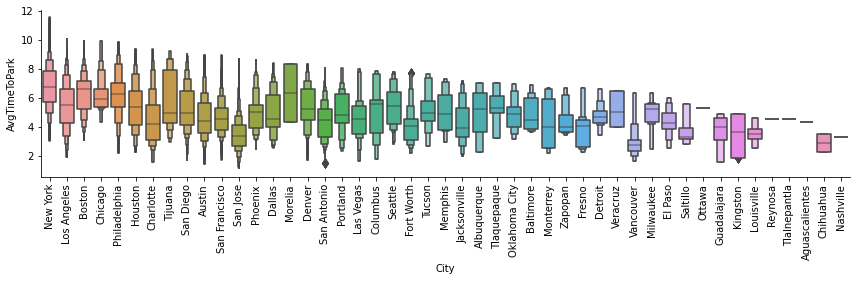

<Figure size 432x288 with 0 Axes>

In [30]:
sns.catplot(y = "AvgTimeToPark", x = "City", data = allin.sort_values("AvgTimeToPark", ascending = False), kind="boxen", height = 4, aspect = 3)

#g.set_xticklabels(rotation=90)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
plt.savefig('boxplotforcitiesavgpark.jpg')

#### Distribution plot for the average time to park for the data set 

#### the distribution plot is fairly normal. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


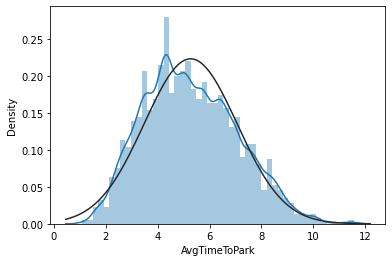

In [31]:
#Check the distribution to see the normalized data
sns.distplot(allin['AvgTimeToPark'] , fit=norm);

#### Correlation heat map for the correlation plot for the features used in the model

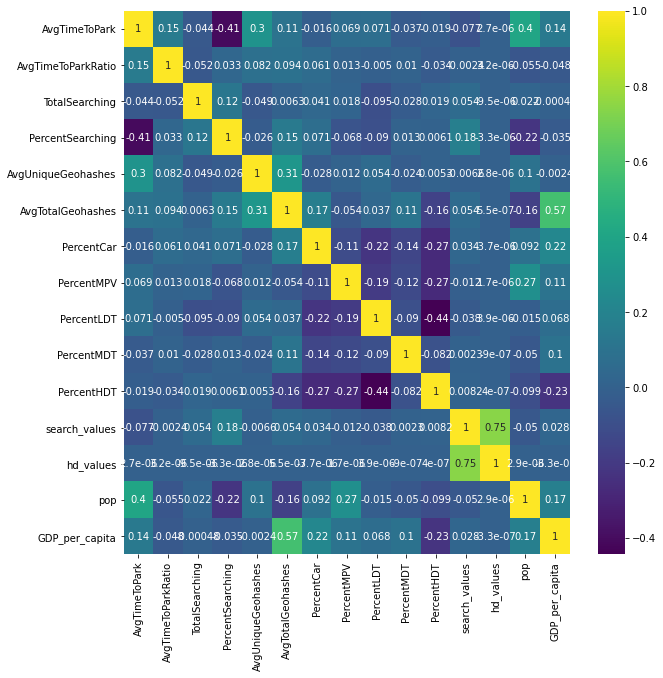

In [32]:
# Create correlation matrix
corr_matrix = allin2.corr()

fig = plt.figure(figsize= (10,10))
sns.heatmap(corr_matrix, annot=True, vmax=1, cmap='viridis', square=False)

### Feature Engineering


Data Cleaning

In [33]:
#assessing all the columns in the data that have missing data 
forever=round(allin2.isnull().mean()*100,2)

In [34]:
forever

City                  0.0
State                 0.0
Country_x             0.0
AvgTimeToPark         0.0
AvgTimeToParkRatio    0.0
TotalSearching        0.0
PercentSearching      0.0
AvgUniqueGeohashes    0.0
AvgTotalGeohashes     0.0
PercentCar            0.0
PercentMPV            0.0
PercentLDT            0.0
PercentMDT            0.0
PercentHDT            0.0
search_values         0.0
hours                 0.0
hd_values             0.0
pop                   0.0
GDP_per_capita        0.0
dtype: float64

thus no missing data to clean up

#### Dealing with Skewed data

In [36]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in allin2.columns:
    if allin2[i].dtype in numeric_dtypes:
        numeric.append(i)

[Text(0.5, 1.0, 'Numeric Distribution of Features')]

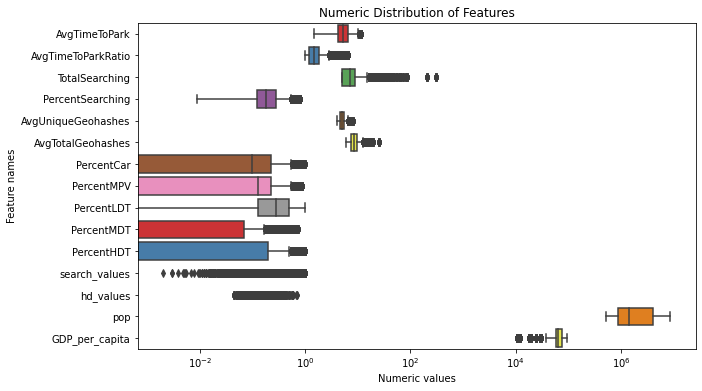

In [37]:
# Create box plots for all numeric features
#sns.set_style("white")
f, ax = plt.subplots(figsize=(10, 6))
ax.set_xscale("log")
ax = sns.boxplot(data=allin2[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
#sns.despine(trim=True, left=True)

In [38]:
# Find skewed numerical features
skew_features = allin2[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 13 numerical features with Skew > 0.5 :


TotalSearching        15.912909
AvgTimeToParkRatio     2.813156
PercentMDT             2.571143
search_values          2.433941
hd_values              1.857973
PercentHDT             1.770904
AvgTotalGeohashes      1.739402
PercentCar             1.379451
PercentMPV             1.322185
pop                    1.170779
dtype: float64

using box cox transformation to normalize the data and address the skew

In [39]:
# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


In [40]:
# Normalize skewed features
for i in skew_index:
    allin2[i] = boxcox1p(allin2[i], boxcox_normmax(allin2[i] + 1))

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


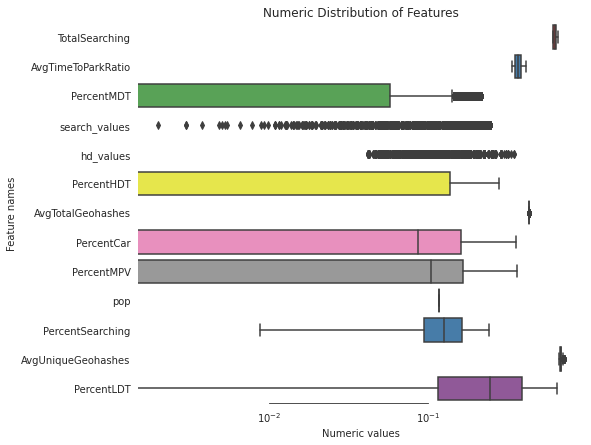

In [41]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=allin2[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

#### Utilizing dummy variables for the categorical variables

In [42]:
allin2 = pd.get_dummies(allin2).reset_index(drop=True)
allin2.head()

,AvgTimeToPark,AvgTimeToParkRatio,TotalSearching,PercentSearching,AvgUniqueGeohashes,AvgTotalGeohashes,PercentCar,PercentMPV,PercentLDT,PercentMDT,PercentHDT,search_values,hd_values,pop,GDP_per_capita,City_Aguascalientes,City_Albuquerque,City_Austin,City_Boston,City_Charlotte,City_Chicago,City_Chihuahua,City_Columbus,City_Dallas,City_Denver,City_Detroit,City_El Paso,City_Fresno,City_Guadalajara,City_Houston,City_Jacksonville,City_Las Vegas,City_Los Angeles,City_Memphis,City_Milwaukee,City_Monterrey,City_Morelia,City_Nashville,City_New York,City_Ottawa,...,State_Nevada,State_New Mexico,State_New York,State_North Carolina,State_Nuevo León,State_Ohio,State_Oregon,State_Pennsylvania,State_Tamaulipas,State_Tennessee,State_Texas,State_Veracruz,State_Washington,State_Wisconsin,Country_x_Mexico,Country_x_United States of America (the),hours_00,hours_01,hours_02,hours_03,hours_04,hours_05,hours_06,hours_07,hours_08,hours_09,hours_10,hours_11,hours_12,hours_13,hours_14,hours_15,hours_16,hours_17,hours_18,hours_19,hours_20,hours_21,hours_22,hours_23
0,6.993,0.382548,0.61678,0.136619,0.709577,0.434687,0.0,0.0,0.556822,0.0,0.0,0.0,0.0,0.118034,44725.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6.993,0.382548,0.61678,0.136619,0.709577,0.434687,0.0,0.0,0.556822,0.0,0.0,0.0,0.0,0.118034,44725.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6.993,0.382548,0.61678,0.136619,0.709577,0.434687,0.0,0.0,0.556822,0.0,0.0,0.0,0.0,0.118034,44725.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6.993,0.382548,0.61678,0.136619,0.709577,0.434687,0.0,0.0,0.556822,0.0,0.0,0.0,0.0,0.118034,44725.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6.993,0.382548,0.61678,0.136619,0.709577,0.434687,0.0,0.0,0.556822,0.0,0.0,0.0,0.0,0.118034,44725.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Regression Analysis

Three types of regression are chosen for the analysis: Linear Regression, Decision Tree Regression and Random Forest Regression

### Linear Regression

In [43]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [44]:
X=allin2.drop(['AvgTimeToPark'],axis=1)
y=allin2.AvgTimeToPark

In [45]:
# Create a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [46]:
#Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Default linear regression

In [47]:
model = LinearRegression()
model.fit(X_train, y_train)

print(f"R^2 score on training set: {model.score(X_train, y_train):0.3f}")
print(f"R^2 score on test set: {model.score(X_test, y_test):0.3f}")

R^2 score on training set: 0.515
R^2 score on test set: 0.514


In [48]:
#defining the coefficients of the dataset
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

In [49]:
coeff1=coeff_df.sort_values(by=['Coefficient'], ascending=False)

#### the most postive coefficients

In [50]:
coeff1.head()

,Coefficient
State_North Carolina,7.062873e+12
State_Texas,6.778886e+12
State_Chihuahua,6.514796e+12
hours_04,5.775635e+12
hours_14,5.773381e+12


#### the most negative coefficients

In [51]:
coeff1.tail()

,Coefficient
City_Jacksonville,-5.613247e+12
State_Nuevo León,-5.628464e+12
City_Guadalajara,-6.033594e+12
City_Charlotte,-7.445505e+12
City_Chihuahua,-7.700723e+12


In [52]:
y_pred = model.predict(X_test)

In [53]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.969009284914002
Mean Squared Error: 1.5093398005676664
Root Mean Squared Error: 1.2285519120361443


### Other models

Key features of the model training process:

Cross Validation: Using 12-fold cross-validation

Models: On each run of cross-validation I fit 4 models (ridge, random forest, xgboost, lightgbm regressors)

Stacking: In addition, I trained a meta StackingCVRegressor optimized using xgboost

Blending: All models trained will overfit the data to varying degrees. Therefore, to make final predictions, I blended their predictions together to get more robust predictions.


In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score

In [55]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [56]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

Models

In [57]:
# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [72]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))
  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, ridge, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

Training the models

In [60]:
scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 0.8150 (0.0162)


In [64]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

[22:21:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:32:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:38:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:50:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:02:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [62]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.40405e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.12824e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.77316e-18): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.60746e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.80675e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAl

ridge: 1.2320 (0.0190)


In [66]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.2290 (0.0117)


Fitting the models 

In [74]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train))

stack_gen
[01:02:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:07:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:12:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:18:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:23:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.18601e-18): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.08797e-16): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.49815e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.82649e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.87432e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAl

[01:48:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:55:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.15025e-18): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.36882e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.08928e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.38475e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.27788e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAl

In [67]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X_train, y_train)

lightgbm


In [69]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X_train, y_train)

xgboost
[00:50:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [68]:
print('Ridge')
ridge_model_full_data = ridge.fit(X_train, y_train)


Ridge


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.15025e-18): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.36882e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.08928e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.38475e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.27788e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAl

In [70]:
print('RandomForest')
rf_model_full_data = rf.fit(X_train, y_train)

RandomForest


Blended models and predictions

In [86]:
y_preds = ridge_model_full_data.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_preds)))

Mean Squared Error: 1.5083894354446232
Root Mean Squared Error: 1.228165068484128


In [87]:
y_preds = xgb_model_full_data.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_preds)))

Mean Squared Error: 0.1860106017076532
Root Mean Squared Error: 0.4312894639423194


In [88]:
y_preds = rf_model_full_data.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_preds)))

Mean Squared Error: 0.05532649659318705
Root Mean Squared Error: 0.2352158510670296


In [89]:
y_preds = lgb_model_full_data .predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_preds)))

Mean Squared Error: 0.662823980257931
Root Mean Squared Error: 0.8141400249698642


In [75]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

In [76]:
# Get final precitions from the blended model
blended_score = rmsle(y_test, blended_predictions(X_test))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)


RMSLE score on train data:
1.7877185329014043


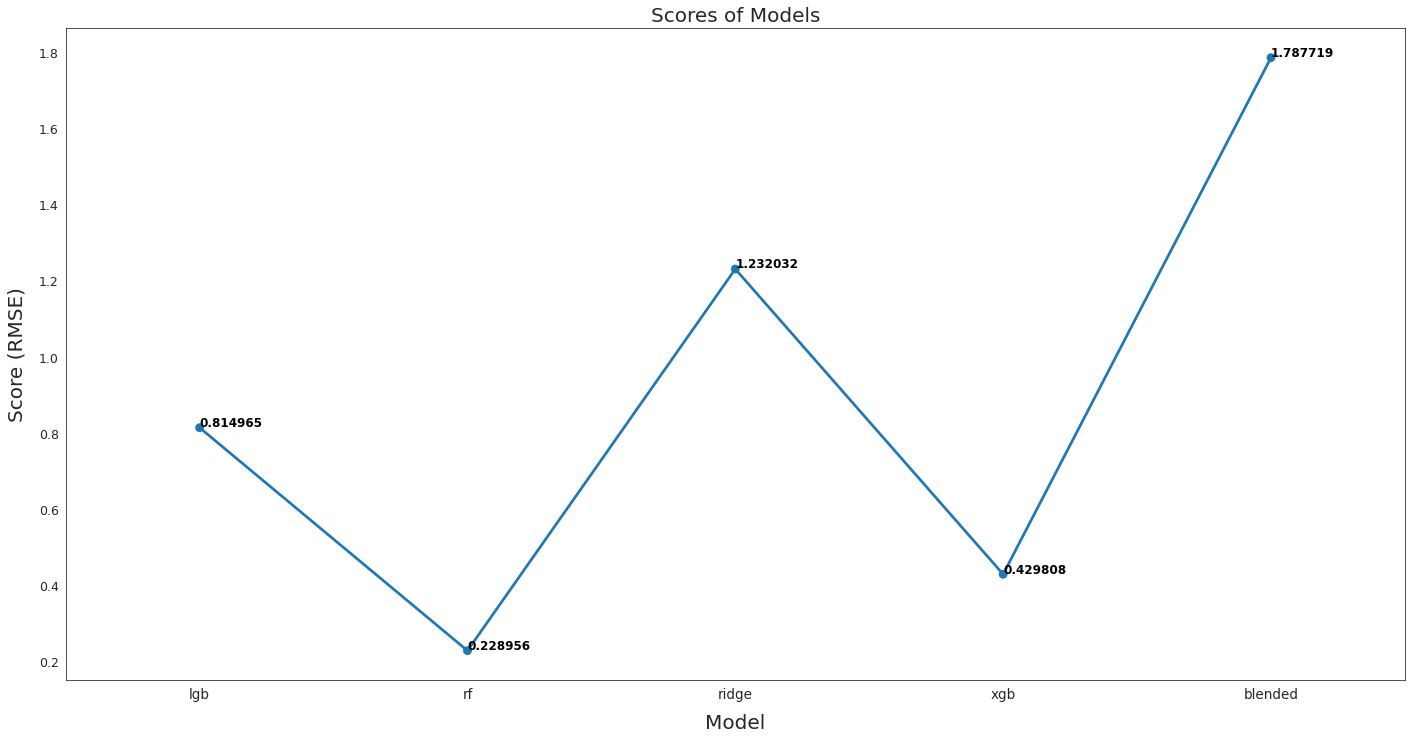

In [77]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

### Decision Tree Regression

#### Initial Decision tree regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint

In [ ]:
DTmodel = DecisionTreeRegressor()
DTmodel.fit(X_train, y_train)

print(f"R^2 score on training set: {DTmodel.score(X_train, y_train):0.3f}")
print(f"R^2 score on test set: {DTmodel.score(X_test, y_test):0.3f}")

R^2 score on training set: 1.000
R^2 score on test set: 1.000


#### Optimized decision tree regression

In [ ]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ['mse','mae']}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeRegressor()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'mse', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1}
Best score is 0.5651200195144874


In [ ]:
y_preds = tree_cv.predict(X_test)

In [ ]:
 #Computing r2_score
from sklearn.metrics import r2_score
r2_score(y_test,y_preds)

0.9457117444813177

In [ ]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_preds))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_preds)))

Mean Absolute Error: 0.08745094329767604
Mean Squared Error: 0.15545613971836106
Root Mean Squared Error: 0.3942792661532699


#### Feature importance for the Decision tree model

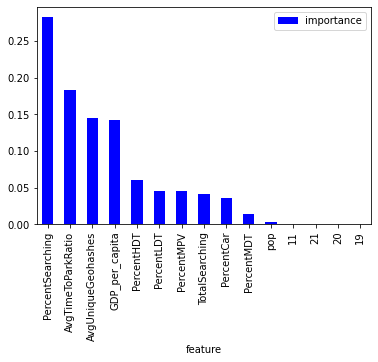

In [ ]:
importances = DTmodel.feature_importances_
feat_names = X.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:15].plot(x='feature', y='importance', kind='bar',color='blue')
plt.savefig('decisontreeimportantfeatures.png')

### Random Forest Regression

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate

In [ ]:
#fitting the initial random forest regressor to the training data
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [ ]:
r2_score = clf.score(X_test, y_test)

In [ ]:
print(r2_score)

1.0


In [ ]:
y_preda = clf.predict(X_test)

In [ ]:
 #Computing r2_score
from sklearn.metrics import r2_score
r2_score(y_test,y_preda)

1.0

In [ ]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 5.970242942824877e-16
Mean Squared Error: 7.412115887982661e-31
Root Mean Squared Error: 8.60936460372231e-16


#### Another Random Forest Regressor using RandomizedsearchCV

In [ ]:
random_grid = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ['mse','mae']}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
clf_random.fit(X_train, y_train)
clf_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7 
[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5 
[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 
[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=5, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3, total=   9.9s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3, total=   8.2s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3, total=  10.7s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3, total=   8.6s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=3, total=   8.8s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8, total=   2.3s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8, total=   2.4s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8, total=   2.3s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8, total=   2.3s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=8, total=   2.1s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2, total=   7.0s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2, total=   7.2s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2, total=   7.8s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2, total=   8.7s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=2, total=   8.4s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1, total=   6.4s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1, total=   7.2s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1, total=   6.9s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1, total=   6.6s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=1, total=   7.1s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   6.8s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   7.4s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   8.0s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   7.5s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   7.3s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.9s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.8s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.9s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.8s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   2.0s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8 ..
[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8 ..
[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8 ..
[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=8, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=   8.0s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=   7.8s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=   8.6s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=   8.0s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=  11.7s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6, total=   7.4s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6, total=   6.9s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6, total=   8.5s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6, total=   7.5s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=6, total=   7.2s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=4, total=   0.3s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5, total=   2.8s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5, total=   2.9s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5, total=   2.9s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5, total=   3.0s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=5, total=   2.6s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1 
[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=1, total=   0.3s
[CV] criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2, total=   5.4s
[CV] criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2, total=   5.7s
[CV] criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2, total=   4.9s
[CV] criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2, total=   4.8s
[CV] criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=2, min_samples_leaf=2, total=   4.9s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=2, total=   0.3s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   7.7s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   7.1s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   9.4s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   8.4s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   8.0s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8 
[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8, total=   0.4s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8, total=   0.5s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8, total=   0.5s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=8, total=   0.5s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4, total=   8.9s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4, total=   8.6s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4, total=   8.3s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4, total=   8.6s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=4, total=   8.5s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6, total=   6.6s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6, total=   6.8s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6, total=   9.2s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6, total=   6.4s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=6, total=   7.1s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   6.6s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   7.5s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   7.9s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   6.8s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=5, total=   7.2s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 
[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 
[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4, total=   6.9s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4, total=   8.8s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4, total=   6.8s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4, total=   7.1s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=4, total=   7.4s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.5s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.3s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.1s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.4s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.3s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   7.8s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   9.5s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   7.9s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   8.0s
[CV] criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=7, min_samples_leaf=4, total=   7.9s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7, total=   3.8s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7, total=   2.1s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7, total=   2.3s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7, total=   2.3s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=7, total=   2.3s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=1, total=   0.2s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   5.3s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   5.9s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   5.8s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   7.4s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   5.8s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=5, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=1, total=   0.2s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8, total=   3.1s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8, total=   3.2s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8, total=   3.5s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8, total=   3.5s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=8, total=   3.1s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3, total=   2.5s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3, total=   2.9s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3, total=   3.3s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3, total=   2.8s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=3, total=   2.6s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3 
[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=5, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4 
[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=8, min_samples_leaf=4, total=   0.1s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.1s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.3s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.0s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.3s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.5s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=5, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=6, total=   0.3s
[CV] criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarni

[CV]  criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=1, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7 ..
[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7 ..
[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=2, min_samples_leaf=7, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3 
[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=3, total=   0.3s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=2, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3, total=   6.8s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3, total=   7.6s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3, total=   7.0s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3, total=   6.4s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=3, total=   6.2s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=7, min_samples_leaf=1, total=   0.3s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4, total=   5.3s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4, total=   5.7s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4, total=   4.9s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4, total=   5.0s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=4, total=   5.1s
[CV] criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7, total=   5.0s
[CV] criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7, total=   4.7s
[CV] criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7, total=   4.5s
[CV] criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7, total=   4.5s
[CV] criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=7, min_samples_leaf=7, total=   5.2s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=5, total=   0.1s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.1s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.7s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.4s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   5.4s
[CV] criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=8, min_samples_leaf=7, total=   4.8s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6, total=   6.5s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6, total=   6.3s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6, total=   6.5s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6, total=   7.6s
[CV] criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=5, min_samples_leaf=6, total=   7.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=4, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4, total=   6.3s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4, total=   6.4s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4, total=   6.1s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4, total=   7.5s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=4, total=   6.4s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8, total=   4.7s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8, total=   4.8s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8, total=   4.9s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8, total=   4.8s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=8, total=   5.1s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.2s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.1s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.6s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.3s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=1, total=   0.1s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.9s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.7s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.9s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.8s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=3, total=   1.8s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3, total=   0.5s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3, total=   0.6s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=3, total=   0.6s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1, total=   0.6s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1, total=   0.5s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1, total=   0.4s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=5, min_samples_leaf=1, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8 
[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8 
[CV]  criterion=mse, max_depth=None, max_features=4, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=8, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.5s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.8s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.5s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.7s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.7s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2 
[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=2, total=   0.2s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7, total=   9.4s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7, total=   7.1s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7, total=   6.6s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7, total=   6.6s
[CV] criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=6, min_samples_leaf=7, total=   6.8s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5, total=   1.7s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5, total=   3.3s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5, total=   2.3s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5, total=   1.8s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=5, total=   1.8s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3 
[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3 
[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3 
[CV]  criterion=mse, max_depth=None, max_features=1, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 
[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=2, min_samples_leaf=4, total=   0.2s
[CV] criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8, total=   3.6s
[CV] criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8, total=   3.9s
[CV] criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8, total=   3.7s
[CV] criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8, total=   3.9s
[CV] criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=5, min_samples_leaf=8, total=   4.0s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=6, total=   0.1s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.4s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.6s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.2s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.2s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.2s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=   8.7s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=   7.8s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=  10.8s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=   8.1s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=7, total=   7.8s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8, total=   4.1s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8, total=   3.8s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8, total=   2.9s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8, total=   2.8s
[CV] criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=3, min_samples_leaf=8, total=   2.8s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6 ..
[CV]  criterion=mse, max_depth=3, max_features=7, min_samples_leaf=6, total=   0.2s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.4s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.1s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.3s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.3s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=2, total=   3.3s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7, total=   4.8s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7, total=   7.1s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7, total=   4.9s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7, total=   5.0s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=7, total=   5.1s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1, total=   4.4s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1, total=   4.6s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1, total=   4.4s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1, total=   4.6s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=1, total=   3.6s
[CV] criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8, total=   4.0s
[CV] criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8, total=   4.6s
[CV] criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8, total=   4.4s
[CV] criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8, total=   3.9s
[CV] criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=6, min_samples_leaf=8, total=   3.9s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=4, total=   0.1s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.3s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.1s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.1s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.3s
[CV] criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=4, min_samples_leaf=1, total=   3.5s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7, total=   0.3s
[CV] criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=8, min_samples_leaf=7, total=   0.3s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3, total=   3.7s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3, total=   7.3s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3, total=   3.9s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3, total=   3.7s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=3, total=   3.7s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2, total=   1.8s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2, total=   1.8s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2, total=   1.7s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2, total=   1.7s
[CV] criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=1, min_samples_leaf=2, total=   1.8s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2, total=   0.2s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2 ..
[CV]  criterion=mse, max_depth=3, max_features=6, min_samples_leaf=2, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8 ..
[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8 ..
[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=4, min_samples_leaf=8, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.6s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.7s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.6s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   4.1s
[CV] criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=1, min_samples_leaf=4, total=   3.9s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1, total=   2.1s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1, total=   2.3s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1, total=   2.2s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1, total=   2.1s
[CV] criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=2, min_samples_leaf=1, total=   2.3s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   5.8s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   5.6s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   5.8s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   6.0s
[CV] criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=4, min_samples_leaf=5, total=   5.5s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 
[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 
[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7 
[CV]  criterion=mse, max_depth=None, max_features=3, min_samples_leaf=7, total=   0.2s

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3 ..


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3, total=   0.1s
[CV] criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3 ..
[CV]  criterion=mse, max_depth=3, max_features=3, min_samples_leaf=3, total=   0.1s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4, total=   5.5s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4, total=   5.7s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4, total=   5.5s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4, total=   4.5s
[CV] criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=3, min_samples_leaf=4, total=   5.2s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1, total=   7.8s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1, total=  11.2s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1, total=   9.2s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1, total=   8.8s
[CV] criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  criterion=mae, max_depth=None, max_features=8, min_samples_leaf=1, total=   8.9s


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 22.9min finished
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'criterion': 'mae',
 'max_depth': None,
 'max_features': 8,
 'min_samples_leaf': 1}

In [ ]:
ans = clf_random.predict(X_test)

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy


In [ ]:
best_random = clf_random.best_estimator_
random_accuracy = evaluate(best_random,X_test, y_test)

Model Performance
Average Error: 0.0539 degrees.
Accuracy = 98.89%.


In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, ans)


0.9935728712930098

In [ ]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ans))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, ans))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, ans)))

Mean Absolute Error: 0.053949244966443335
Mean Squared Error: 0.01840428668624161
Root Mean Squared Error: 0.1356623996774405


#### Feature importance based on the un optimized model

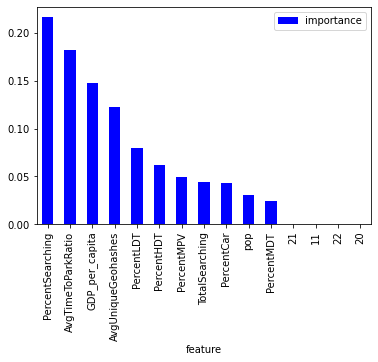

In [ ]:
importances = clf.feature_importances_
feat_names = X.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:15].plot(x='feature', y='importance', kind='bar',color='blue')
plt.savefig('decisontreeimportantfeatures.png')